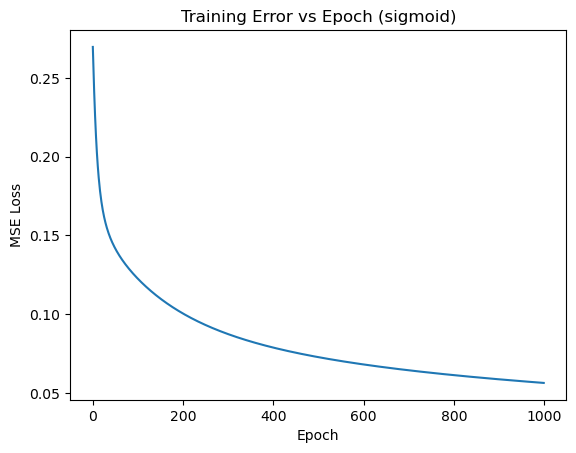

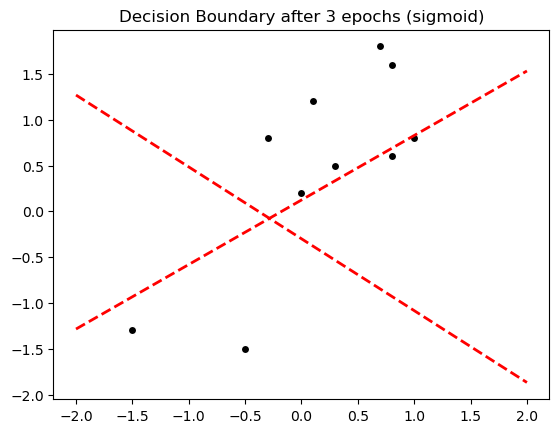

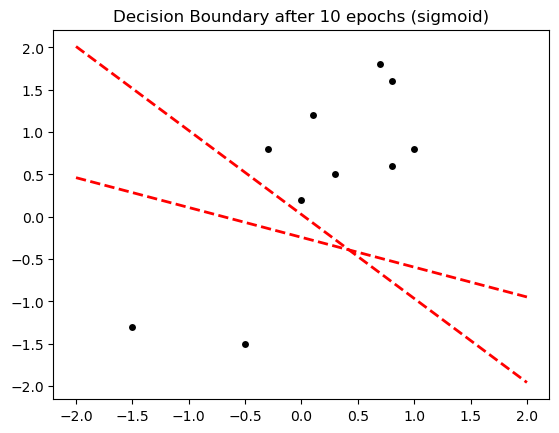

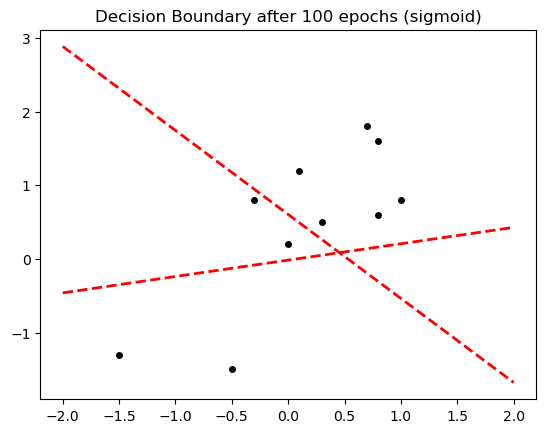

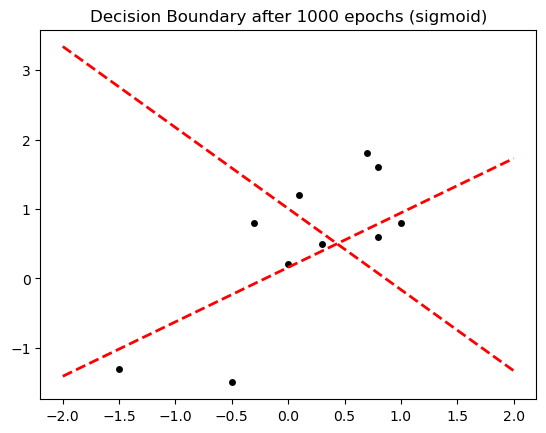

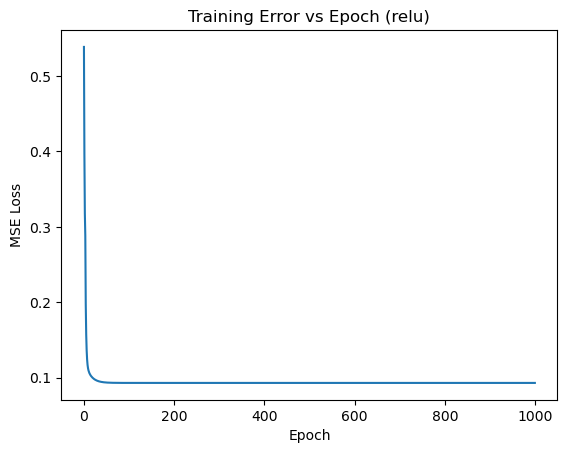

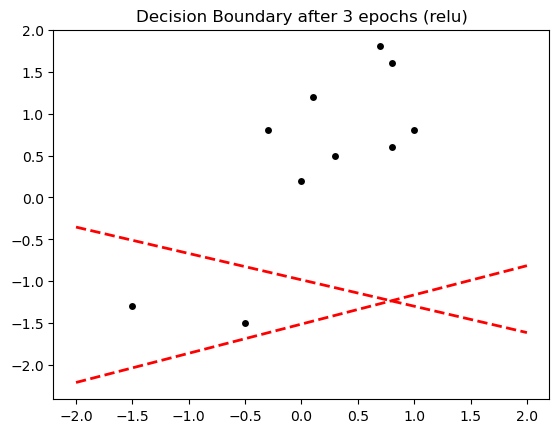

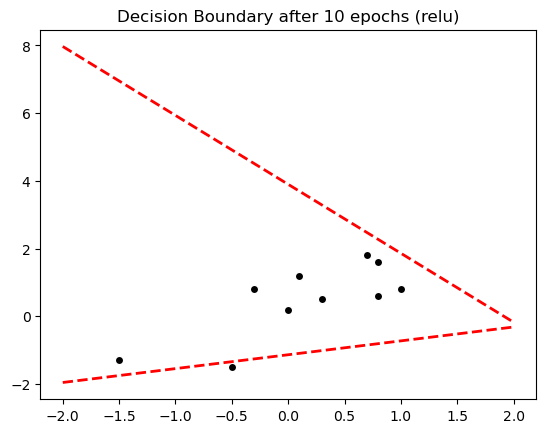

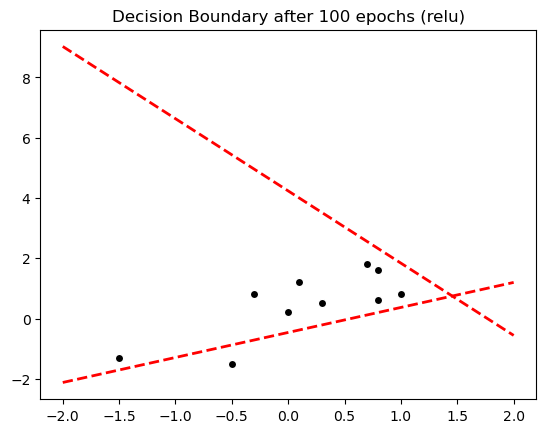

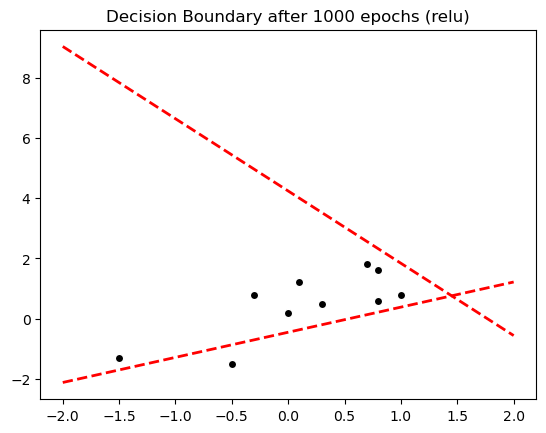

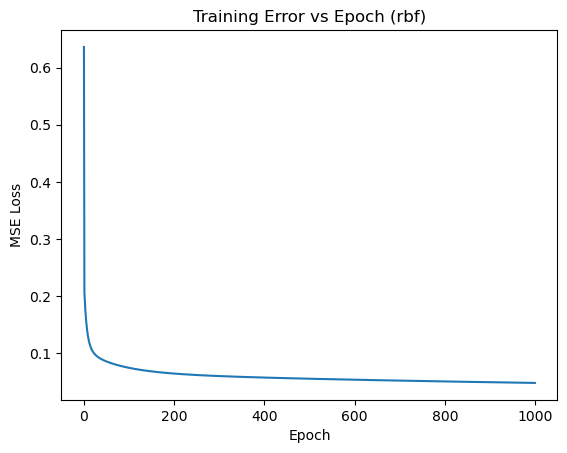

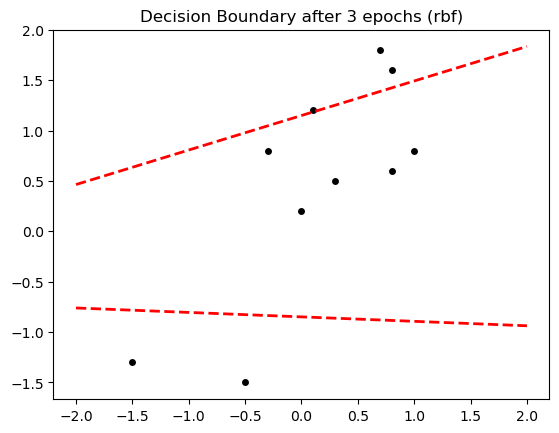

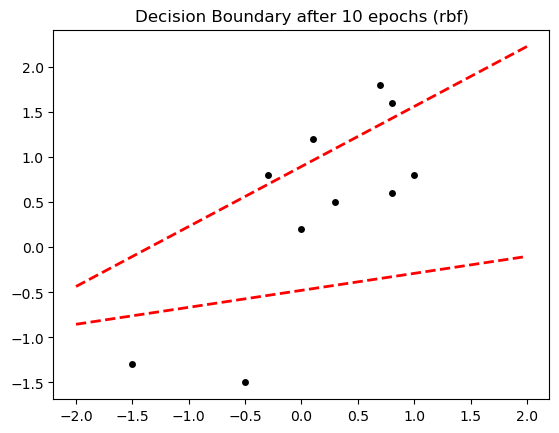

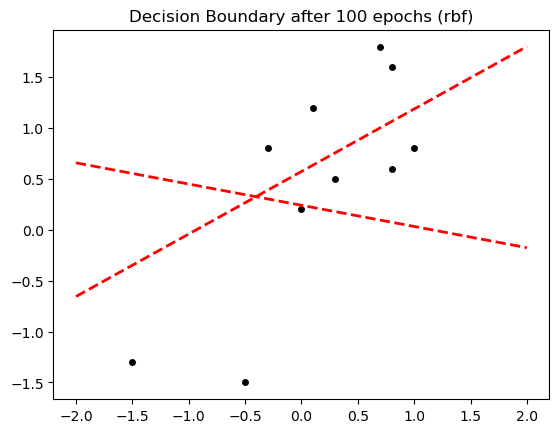

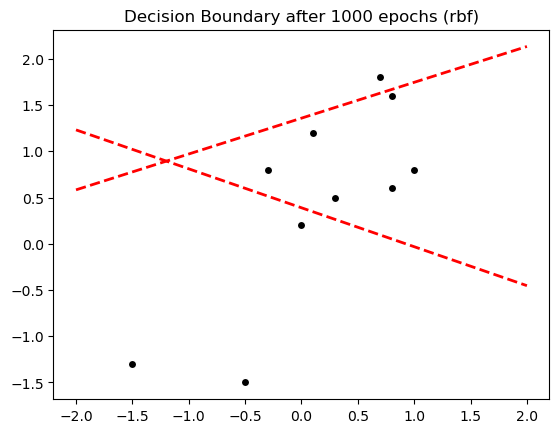

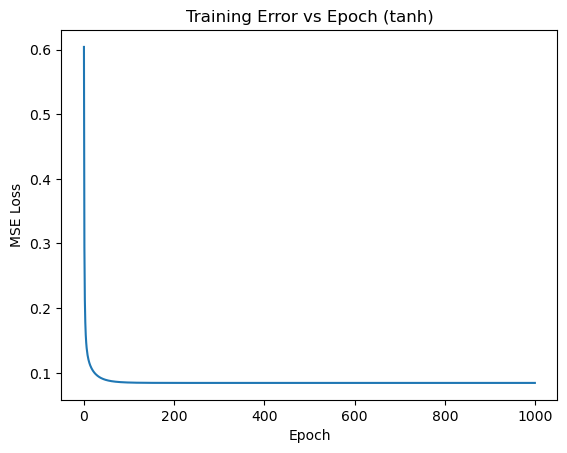

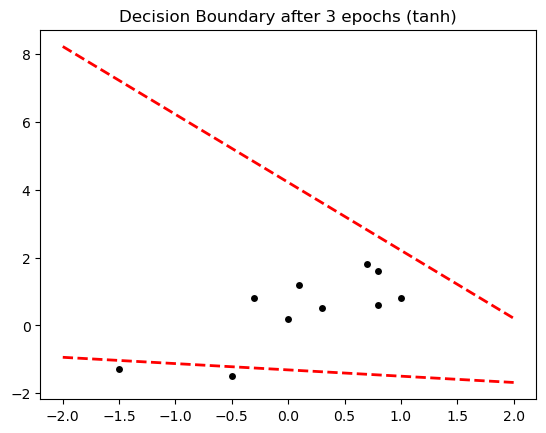

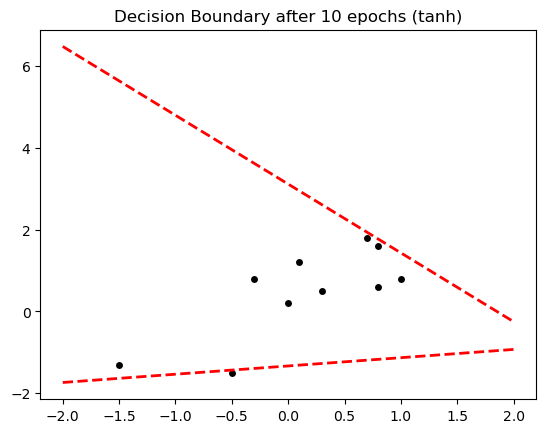

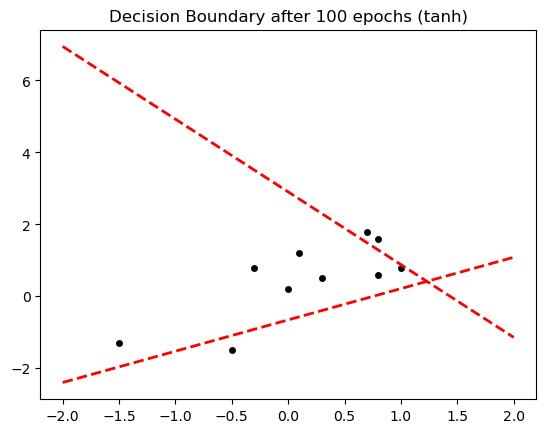

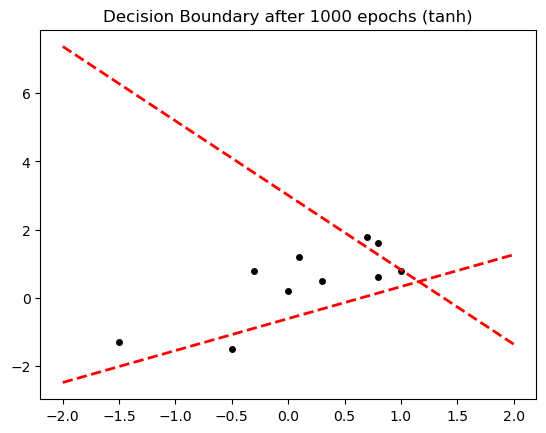

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ONE-LAYER Neural Network with multiple activation functions
# Input: 2 neurons (x1, x2)
# Output: 2 neurons (binary codes for 4 classes)
# Supported activations: sigmoid (logsig), tanh (tansig), relu, rbf

# 1. Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

# Radial Basis Function (Gaussian)
def rbf(X, centers, sigma=1.0):
    # X: (2,N), centers: (H,2)
    N = X.shape[1]
    H = centers.shape[0]
    A = np.zeros((H, N))
    for i in range(H):
        diff = X.T - centers[i]
        A[i,:] = np.exp(-np.sum(diff**2, axis=1) / (2*sigma**2))
    return A

# 2. Dataset
X = np.array([[0.1, 0.7, 0.8, 0.8, 1.0, 0.3, 0.0, -0.3, -0.5, -1.5],
              [1.2, 1.8, 1.6, 0.6, 0.8, 0.5, 0.2,  0.8, -1.5, -1.3]])

Y = np.array([[1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])

# 3. Training function

def train_nn(X, Y, activation="sigmoid", epochs=1000, lr=0.2, H=5):
    np.random.seed(42)
    N = X.shape[1]

    if activation == "rbf":
        centers = X.T[np.random.choice(N, H, replace=False)]
        sigma = 1.0
        W = np.random.randn(Y.shape[0], H) * 0.1
        b = np.zeros((Y.shape[0], 1))
    else:
        W = np.random.randn(Y.shape[0], X.shape[0]) * 0.1
        b = np.zeros((Y.shape[0], 1))

    errors = []
    snapshots = {3: None, 10: None, 100: None, 1000: None}

    for epoch in range(1, epochs+1):
        if activation == "sigmoid":
            Z = np.dot(W, X) + b
            A = sigmoid(Z)
            dA_dZ = sigmoid_derivative(Z)
        elif activation == "tanh":
            Z = np.dot(W, X) + b
            A = tanh(Z)
            dA_dZ = tanh_derivative(Z)
        elif activation == "relu":
            Z = np.dot(W, X) + b
            A = relu(Z)
            dA_dZ = relu_derivative(Z)
        elif activation == "rbf":
            A = rbf(X, centers, sigma)
            Z = np.dot(W, A) + b
            dA_dZ = None

        Y_pred = A if activation != "rbf" else Z

        loss = np.mean((Y_pred - Y)**2)
        errors.append(loss)

        dL_dY = (2/N) * (Y_pred - Y)

        if activation in ["sigmoid", "tanh", "relu"]:
            dZ = dL_dY * dA_dZ
            dW = np.dot(dZ, X.T)
            db = np.sum(dZ, axis=1, keepdims=True)
            W -= lr * dW
            b -= lr * db
        elif activation == "rbf":
            dW = np.dot(dL_dY, A.T)
            db = np.sum(dL_dY, axis=1, keepdims=True)
            W -= lr * dW
            b -= lr * db

        if epoch in snapshots:
            snapshots[epoch] = (W.copy(), b.copy(), centers if activation=="rbf" else None)

    return errors, snapshots

# 4. Plot decision boundaries
def plot_decision_boundary(W, b, X, Y, activation, title, centers=None, sigma=1.0):
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.array([xx.ravel(), yy.ravel()])

    if activation == "sigmoid":
        Z = np.dot(W, grid) + b
        Y_pred = sigmoid(Z)
    elif activation == "tanh":
        Z = np.dot(W, grid) + b
        Y_pred = tanh(Z)
    elif activation == "relu":
        Z = np.dot(W, grid) + b
        Y_pred = relu(Z)
    elif activation == "rbf":
        A = rbf(grid, centers, sigma)
        Z = np.dot(W, A) + b
        Y_pred = Z

    # Training points
    for i in range(Y.shape[1]):
        plt.scatter(X[0,i], X[1,i], c='k', edgecolors='w')

    # Raw decision boundary lines (for linear-based activations)
    if activation in ["sigmoid", "tanh", "relu", "rbf"]:
        for i in range(W.shape[0]):
            w1, w2 = W[i,0], W[i,1]
            b_i = b[i,0]
            if abs(w2) > 1e-6:
                x_vals = np.linspace(x_min, x_max, 200)
                y_vals = -(w1/w2) * x_vals - (b_i/w2)
                plt.plot(x_vals, y_vals, 'r--', linewidth=2)

    plt.title(title)
    plt.show()

# 5. Run and plot results
functions = ["sigmoid", "relu", "rbf", "tanh"]

for activation_choice in functions:
    errors, snapshots = train_nn(X, Y, activation=activation_choice, epochs=1000)
    
    plt.plot(errors)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"Training Error vs Epoch ({activation_choice})")
    plt.show()


    for e, snap in snapshots.items():
        if snap is not None:
            W_snap, b_snap, centers = snap
            plot_decision_boundary(
                W_snap, b_snap, X, Y, activation_choice,
                f"Decision Boundary after {e} epochs ({activation_choice})",
                centers
            )